# Applied Data Science Capstone Project

Dominique Cadosch, 10 October 2020

This case study is the Applied Data Science Capstone Project in the IBM Data Science Professional Program. This study does not only serve as a demonstration of the skills that I have acquired, hopefully it can also demonstrate the power and versatility of common data science methods. The audience of this article are not necessarily just scientist and researchers but the general public and especially those with an interest in the applications of data science.

All the code as well as the used data set can be found on GitHub https://github.com/dcadosch/Coursera_Capstone

## Introduction

At least since we use wheeled motor vehicles for transportation, traffic collisions are an unfortunate but inherent aspect of it. The severity of accidents varies for a number of reasons. Roads may not be designed in a safe way or crucial parts of vehicles may fail while driving due to insufficient maintenance or due to engineering faults of the vehicle manufacturer. The driver may be distracted or violate safety rules and laws by speeding or driving under the influence of alcohol or drugs. There are also environmental factors that may influence the severity of a collision. A law-abiding driver who takes appropriate care of her or his vehicle can only influence a few of these factors that govern the outcome of a collision. However, it is difficult to judge these factors without a thorough analysis of the data of past collision events.

In this case study I am creating a machine learning model that estimates the severity of collision events based on a number of environmental factors. The severity of collisions is divided into multiple classes, which means that we need to employ a classification algorithm. In order to be able to choose an optimal classification algorithm, we will deploy multiple methods and compare their performance by measuring several evaluation metrics.

This case study will focus on traffic accidents in an urban environment in the United States of America. Hence, it might not be applicable to situations that differ considerably from such a scenario. The general approach of this study might nonetheless serve as a guide to create a similar model with data from another source.

## Data Understanding

The data to train and evaluate the model was obtained from the 'City of Seattle Open Data Portal' (https://data.seattle.gov/Land-Base/Collisions/9kas-rb8d). The data set contains all reported vehicle collisions in Seattle from January 1, 2004 to October 9, 2020. The table contains 40 columns and 221,525 incidents. Not all of the columns contain relevant or usable information for the task at hand. Furthermore, not all incidents have a complete set of information. These incidents may need to be removed from the data set.

The most relevant feature is the severity of an accident. In the original data set the severity is divided into four classes: property damage, injury, serious injury, and fatality. The model will be trained to predict the severity class based on other available information. Independent features that a driver may observe before a collision occurs are for example the road and light conditions, the weather and the kind of road (s)he is in. All these features are divided into about ten classes each. Other features such as the month of the year or the time of the day may be extracted from the timestamp in the data set. Collision data that can only be obtained after the collision occurred such as the type of collision or whether any person involved was driving under influence will not be used in the training of the classification algorithms.

In [86]:
# load necessary data handling libraries
import numpy as np
import pandas as pd

In [87]:
# this line completes a task that was part of an assignment
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [88]:
# read csv file and store it in a data frame
df = pd.read_csv('Collisions.csv')

C:\Users\admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [89]:
# get an overview of the data structure and content
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,1.268354e+06,265256.609668,1,1003,1003,3503158,Matched,Block,NaN,AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST,...,Dry,Daylight,Y,NaN,NaN,45,Vehicle - Pedalcyclist,15057,0,N
1,1.259316e+06,202173.388163,2,56200,56200,1795087,Matched,Block,NaN,35TH AVE SW BETWEEN SW MORGAN ST AND SW HOLLY ST,...,Dry,Dark - Street Lights On,NaN,6015003.0,NaN,0,Vehicle going straight hits pedestrian,0,0,N
2,1.264342e+06,259613.000382,3,327037,328537,E979380,Matched,Intersection,37122.0,3RD AVE NW AND NW 100TH ST,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
3,1.279221e+06,222017.872023,4,327278,328778,E996362,Unmatched,Intersection,30602.0,M L KING JR WAY S AND S JACKSON ST,...,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N
4,1.262205e+06,242179.124204,5,1248,1248,3645424,Unmatched,Block,NaN,W EWING ST BETWEEN 6TH AVE W AND W EWING PL,...,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N


In [90]:
# get the size of the data frame
df.shape

(221525, 40)

In [91]:
# The X and Y coordinates in the original csv file to not correspond to latitude and longitude measures. Longitude and
# latitude coordinates are available in a geojson file that can be downloaded from the same site as the data set in the csv
# format. The json library will be needed to load the geojson file.

import json

with open('Collisions.geojson') as f:
    data = json.load(f)

In [92]:
# A secondary data frame with a key column (INCKEY) will be created to store the extracted coordinates. The private key will
# be used to merge the two data frames. In order to predefine the data frame to have the appropriate size it will copy the
# 'INCKEY', 'X', 'Y' column from the original data frame and subsequently be overwritten with the extracted data from the
# geojson file. This is probably faster than appending rows for every extracted incident.

df_coordinates = df.loc[:,['INCKEY']]

df_coordinates['LATITUDE'] = df['X']
df_coordinates['LONGITUDE'] = df['Y']

# overwrite data frame to make sure that no original information will remain
df_coordinates.loc[:,:] = None

In [93]:
# Create a loop to cycle through all the entries in the geojson data frame, extract the INCKEY and the coordinates, and store
# them in the secondary data frame.

loop_count = 0

for feature in data['features']:
    # Some entries do not have coordinates. Check whether they exist, otherwise an error will occur.
    if feature['geometry'] != None:
        df_coordinates.loc[loop_count, 'LATITUDE'] = feature['geometry']['coordinates'][1]
        df_coordinates.loc[loop_count, 'LONGITUDE'] = feature['geometry']['coordinates'][0]
    df_coordinates.loc[loop_count, 'INCKEY'] = feature['properties']['INCKEY']
    loop_count += 1

In [94]:
# Merge / inner join the two data frames based on the INCKEY column that is present in both data frames.
df = pd.merge(df, df_coordinates, how = 'inner', on = 'INCKEY')

In [95]:
# install the folium package for map visualizations
!conda install -c conda-forge folium=0.11.0 --yes

Solving environment: ...working... done

# All requested packages already installed.



To get an initial overview of the nature of the data that will be used it might be helpful to have a geographic visualization. The following map shows all recorded collision incidents in 2020 up to October 9 for which the coordinates were available. The severity of incidents is divided into four categories and indicated by their color. From this map we can see the boundaries of the geographic area from which the data stems. We can further see that the incidents are not homogeneously distributed. There are certain areas where incidents are clustered. That clustering might be due to higher amounts of traffic, particularly dangerous roads or simply due to stochastic effects. The severity of accidents shows no obvious pattern that would suggest that certain areas cause more serious accidents. Since the geographic distribution of accidents and their corresponding severity does not seem to provide any additional information, we will not use the location data any further in our study.

In [96]:
# Load the folium library and use the newly obtained latitude and longitude coordinates to mark every incident. Because of
# the large number of incidents we will restrict the visualization to incidents that happened in 2020 up to October 9.

import folium

from folium.plugins import FloatImage


seattle_map = folium.Map(location = [47.607568212024205,-122.32992013710938], zoom_start = 11)
seattle_map.add_child(FloatImage('map_legend.png', bottom=80.5, left=80))

df_withLocation = df[df['LATITUDE'].notnull()]

df_limit2020 = df_withLocation[df_withLocation['INCDATE'] > '2020']

accidents = folium.map.FeatureGroup()

for lat, lng, svc in zip(df_limit2020['LATITUDE'], df_limit2020['LONGITUDE'], df_limit2020['SEVERITYCODE']):
    #print(lat, lng)
    if svc == '1':
        marker_col = 'green'
    elif svc == '2':
        marker_col = 'yellow'
    elif svc == '2b':
        marker_col = 'orange'
    elif svc == '3':
        marker_col = 'red'
    else:
        marker_col = 'green'
    
    accidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius = 1, # define how big you want the circle markers to be
            color = marker_col,
            fill = True,
            fill_color = marker_col
        )
    )
    
seattle_map.add_child(accidents)

In [97]:
# we need to have the selenium package and an equally up-to-date installation of Firefox to export the map visualization
!conda install -c conda-forge selenium --yes

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\admin\anaconda3

  added / updated specs:
    - selenium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    selenium-3.141.0           |py37h4ab8f01_1002         938 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         938 KB

The following packages will be UPDATED:

  selenium                        3.141.0-py37h4ab8f01_1001 --> 3.141.0-py37h4ab8f01_1002




selenium-3.141.0     | 938 KB    |            |   0% 
selenium-3.141.0     | 938 KB    | 1          |   2% 
selenium-3.141.0     | 938 KB    | ########## | 100% 
selenium-3.141.0     | 938 KB    | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [98]:
# export the generated map to a png file
import io
from PIL import Image

img_data = seattle_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('seattle_map.png')

## Methodology

### Data cleaning and examination

Before we analyze the data, it is appropriate to take a more in-depth look into the data. Some aspects and features might need to be cleaned or processed to be able to get a better understanding and also to increase the quality of the predictions that the model is supposed to make. First, we look at severity code labels for every incident. According to the metadata of the data set the labels are '1', '2', '2b', and '3', which correspond to 'property damage', 'injury', 'serious injury' and fatality, respectively. However, the data set also contains 21,616 incidents without any label or with the label '0' which does not correspond to any severity class. These incidents cannot be used for the training or evaluation of the model and have to be removed from the data set.

Next we look at the distribution of the remaining incidents according to their severity. Unsurprisingly we see that that the majority of all collisions (68.9%) only cause property damage. 29.4% of all collisions resulted in (light) injury but only a very small percentage involved serious injury or fatality (1.6% and 0.2%). Of course it is very fortunate that only a small proportion of accidents result in a serious outcome. On the other hand this also means that the distribution among classes is very imbalanced. Furthermore, the different classes are not necessarily very distinct from each other but rather subdivisions on a gradient of collision severity. Thus, it is unlikely that we can train a reasonably accurate machine learning model for all four classes. This means that we should simplify the categorization. We do this by grouping incidents in only two classes - collisions that only caused property damage and collisions that have caused physical harm. This will still result in an imbalanced data set with a ratio of about 3 to 7 but this is something that we can handle and every class still has a reasonably high number of incidents to inform the model.

In [99]:
# check about the number of unique severity code labels
df.loc[:,'SEVERITYCODE'].unique()

array(['2', '1', '0', '3', '2b', nan], dtype=object)

In [100]:
# count the number of rows/incidents that will be removed because of their missing/incorrect severity code label
unknowns = df[(df['SEVERITYCODE'].isnull()) | (df['SEVERITYCODE'] == '0')].shape[0]
print(unknowns, 'incidents have been excluded due to the severity being unknown.')

# exclude rows/incidents with unknown severity and overwrite the original data frame
df = df[(df['SEVERITYCODE'].notnull()) & (df['SEVERITYCODE'] != '0')].copy()

# replace the severity code labels with continuous numbers
df.loc[:,'SEVERITYCODE'].replace(['1', '2', '2b', '3'], [0, 1, 2, 3], inplace = True)

21616 incidents have been excluded due to the severity being unknown.


In [101]:
# show number of incidents in each severity class
df['SEVERITYCODE'].value_counts()

0    137671
1     58783
2      3105
3       350
Name: SEVERITYCODE, dtype: int64

In [102]:
# calculate the proportions of each severity class
df['SEVERITYCODE'].value_counts() / df.shape[0] * 100

0    68.866834
1    29.404879
2     1.553207
3     0.175080
Name: SEVERITYCODE, dtype: float64

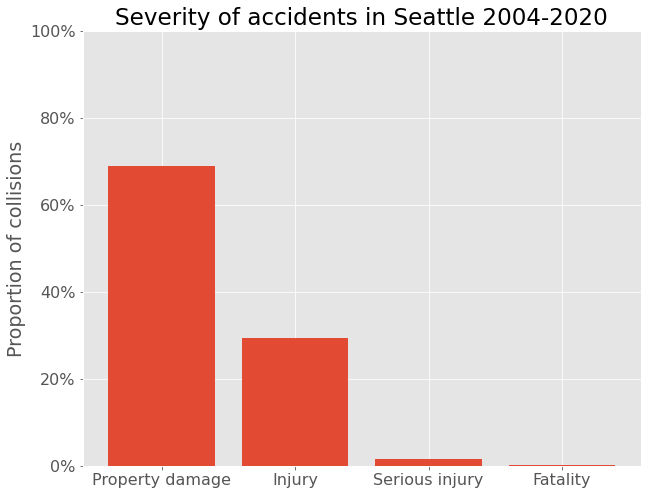

In [103]:
# create a bar chart to visualize the proportion of each severity class among collision events

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

mpl.style.use('ggplot')
plt.rcParams.update({'font.size': 16})

x = df['SEVERITYCODE'].unique().tolist()
x.sort()

fig = plt.figure(figsize = (10,8))

plt.bar(x, df['SEVERITYCODE'].value_counts() / df.shape[0] * 100)

severity_descs = ['Property damage', 'Injury', 'Serious injury', 'Fatality']

plt.xticks(x, labels = severity_descs)
plt.title('Severity of accidents in Seattle 2004-2020')
plt.ylabel('Proportion of collisions')

axes = plt.gca()
axes.set_ylim([0, 100])
axes.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig('severity_class.png')

In [104]:
# relabel all 'serious injury' and 'fatality' collisions to make sure that we only have two classes of severity
df.loc[:,'SEVERITYCODE'].replace([2, 3], 1, inplace = True)

The data set also contains information about the number of people (pedestrians, cyclists, people in vehicles) who were involved in an accident. The number of people who are involved in a collision event correlates with the severity of that collision because the probability of at least one person being (seriously) injured or dead increases with the number of people. Thus, we will not use these features directly. However, the information whether at least one pedestrian, cyclist or vehicle driver was involved in a traffic accident could give us some information about the risk that those three groups face in an accident. So we will create three new binary features that indicate whether at least one pedestrian, cyclist, or vehicle driver was involved in an accident. 

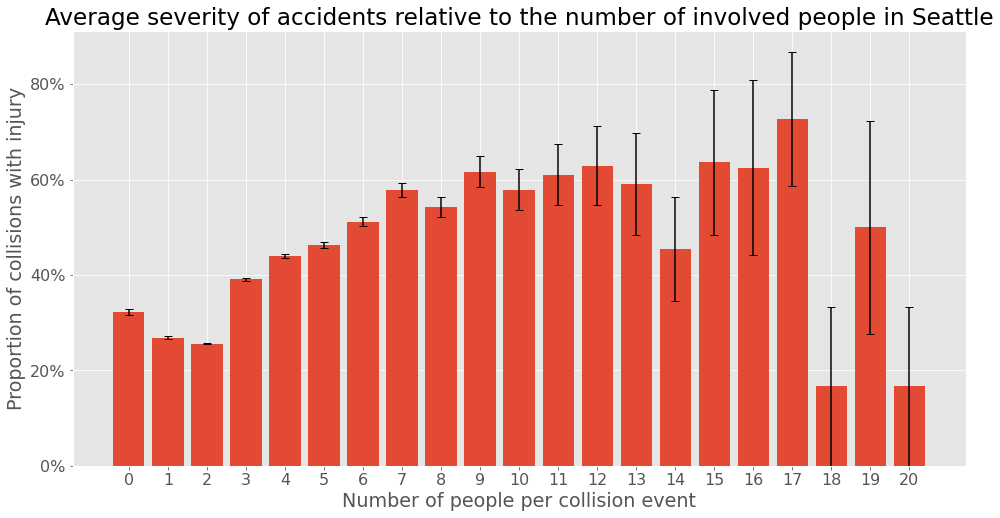

In [105]:
# create a bar chart that shows the average severity of accidents based on the number of people who were involved

plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize = (16,8))

plt.bar(sorted(df['PERSONCOUNT'].unique())[0:21],
        df.groupby('PERSONCOUNT')['SEVERITYCODE'].agg('mean')[0:21] * 100,
        yerr = df.groupby('PERSONCOUNT')['SEVERITYCODE'].agg('sem')[0:21] * 100,
        capsize = 4)

plt.title('Average severity of accidents relative to the number of involved people in Seattle')
plt.ylabel('Proportion of collisions with injury')
plt.xlabel('Number of people per collision event')

plt.xticks(range(0, 21))

axes = plt.gca()
axes.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig('severity_personcount.png')

In [106]:
# create three new columns that determine whether at least one pedestrian, cyclist or vehicle driver was involved in a
# collision

df.loc[:, 'PEDES'] = 0
df.loc[df['PEDCOUNT'] > 0, 'PEDES'] = 1

df.loc[:, 'CYCL'] = 0
df.loc[df['PEDCYLCOUNT'] > 0, 'CYCL'] = 1

df.loc[:, 'VEHIC'] = 0
df.loc[df['VEHCOUNT'] > 0, 'VEHIC'] = 1

In [107]:
# drop all columns that we will not use anymore because they do not contain interesting or useable information

df = df.drop(['X',
              'Y',
              'OBJECTID',
              'INCKEY',
              'INTKEY',
              'SEVERITYDESC',
              'COLLISIONTYPE',
              'PERSONCOUNT',
              'PEDCOUNT',
              'PEDCYLCOUNT',
              'VEHCOUNT',
              'INJURIES',
              'SERIOUSINJURIES',
              'FATALITIES',
              'INCDATE',
              'COLDETKEY', 
              'REPORTNO', 
              'STATUS',
              'ADDRTYPE',
              'LOCATION', 
              'EXCEPTRSNCODE', 
              'EXCEPTRSNDESC',
              'SDOT_COLCODE',
              'SDOT_COLDESC',
              'PEDROWNOTGRNT',
              'SDOTCOLNUM',
              'SEGLANEKEY',
              'CROSSWALKKEY',
              'ST_COLCODE',
              'ST_COLDESC',
              'HITPARKEDCAR',
              'LATITUDE',
              'LONGITUDE'], axis = 1).copy()
#df.loc['OBJECTID'].head()
#df.loc[0:5,'OBJECTID']
df.shape

(199909, 12)

In [108]:
df.head()

,SEVERITYCODE,INCDTTM,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,PEDES,CYCL,VEHIC
0,1,3/14/2013 5:30:00 PM,Driveway Junction,NaN,N,Clear,Dry,Daylight,NaN,0,1,1
1,1,1/15/2006 5:35:00 PM,Mid-Block (not related to intersection),NaN,0,Overcast,Dry,Dark - Street Lights On,NaN,1,0,1
2,0,9/9/2019 3:32:00 PM,At Intersection (intersection related),NaN,N,Overcast,Wet,Daylight,NaN,0,0,1
3,0,12/19/2019,At Intersection (intersection related),NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
5,1,7/7/2005,At Intersection (intersection related),NaN,0,Clear,Dry,Daylight,NaN,0,0,1


The data set contains information about whether the collision happened due to inattention, whether a driver was under the influence of drugs or arcohol (DUI), or whether speeding was a factor. This information is not suitable to be used to inform the model since this can usually only be determined retrospectively. Nonetheless it could be interesting to perform a quick analysis to assess how much these factors influence the severity of a collision.

In [109]:
# replace and standardize the labels for the features that indicate 'inattention', 'speeding', and 'DUI'
df['INATTENTIONIND'].replace([np.nan, 'Y'],[0,1], inplace = True)
df['SPEEDING'].replace([np.nan, 'Y'],[0,1], inplace = True)
df['UNDERINFL'].replace(['N', '0', np.nan, 'Y', '1'], [0, 0, 0, 1, 1], inplace = True)

In [110]:

no_factor = df.loc[(df['INATTENTIONIND'] == 0) & (df['SPEEDING'] == 0) & (df['UNDERINFL'] == 0), 'SEVERITYCODE'].mean()
inattention = df.groupby('INATTENTIONIND')['SEVERITYCODE'].agg('mean')[1]
speeding = df.groupby('SPEEDING')['SEVERITYCODE'].agg('mean')[1]
dui = df.groupby('UNDERINFL')['SEVERITYCODE'].agg('mean')[1]

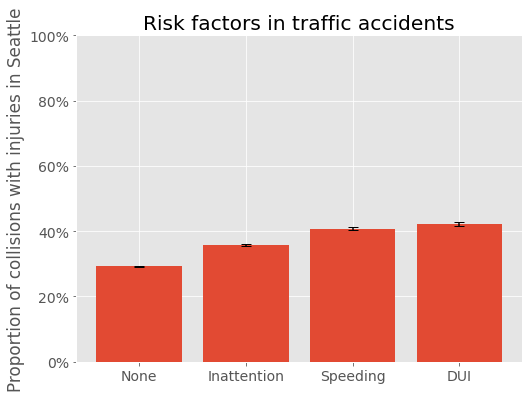

In [111]:
# calculate the proportion of collisions that result in injuries for the categories 'inattention', 'speeding', 'DUI', and
# 'no risk factor'
no_factor = df.loc[(df['INATTENTIONIND'] == 0) & (df['SPEEDING'] == 0) & (df['UNDERINFL'] == 0), 'SEVERITYCODE'].mean()
inattention = df.groupby('INATTENTIONIND')['SEVERITYCODE'].agg('mean')[1]
speeding = df.groupby('SPEEDING')['SEVERITYCODE'].agg('mean')[1]
dui = df.groupby('UNDERINFL')['SEVERITYCODE'].agg('mean')[1]

# calculate the standard error for all collisions that result in injuries for the categories 'inattention', 'speeding',
# 'DUI', and 'no risk factor'
no_factor_sem = df.loc[(df['INATTENTIONIND'] == 0) & (df['SPEEDING'] == 0) & (df['UNDERINFL'] == 0), 'SEVERITYCODE'].sem()
inattention_sem = df.groupby('INATTENTIONIND')['SEVERITYCODE'].agg('sem')[1]
speeding_sem = df.groupby('SPEEDING')['SEVERITYCODE'].agg('sem')[1]
dui_sem = df.groupby('UNDERINFL')['SEVERITYCODE'].agg('sem')[1]

# visualize the proportion of collisions that result in injuries for the categories 'inattention', 'speeding', 'DUI', and
# 'no risk factor'
fig = plt.figure(figsize = (8,6))
plt.rcParams.update({'font.size': 14})

plt.bar(range(0,4), np.multiply([no_factor, inattention, speeding, dui], 100),
        yerr = np.multiply([no_factor_sem, inattention_sem, speeding_sem, dui_sem], 100),
        capsize = 5)



plt.xticks(x, labels = ['None', 'Inattention', 'Speeding', 'DUI'])
plt.title('Risk factors in traffic accidents')
plt.ylabel('Proportion of collisions with injuries in Seattle')

axes = plt.gca()
axes.set_ylim([0, 100])
axes.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig('risk_factors.png')

The bar chart reveals that inattention, speeding and driving under influence (DUI) substantially increase the risk of a collision that involves injuries. Inattention increases the risk by 22.2%, speeding by 39.4%, and DUI by 44.6%.

Among the features that are definitely expected to be informative for the model are the weather, the road conditions, and the light conditions. All three features categorize the conditions in a few classes. For the evaluation of these features it would be helpful to visualize their influence on the severity of collision events.

The 'Weather' feature has 12 different classes. The class 'Blowing Snow' class has only one incident with this designation and will be dismissed due to its insignificance. Furthermore, the class 'Unknown' has 15,131 incidents. Since this class has no informative value the corresponding incidents will also be removed from the data set.

In [112]:
# remove 'Blowing snow' class from data set due to insignificance

blowing_snow = df[df['WEATHER'] == 'Blowing Snow'].shape[0]
print(blowing_snow, 'incidents have been excluded because they belong to a marginal subgroup.')

df = df[df['WEATHER'] != 'Blowing Snow'].copy()

1 incidents have been excluded because they belong to a marginal subgroup.


In [113]:
# remove incidents with unknown weather conditions from the data set

unknown = df[df['WEATHER'] == 'Unknown'].shape[0]
print(unknown, 'incidents have been excluded because their values are unknown.')

df = df[df['WEATHER'] != 'Unknown'].copy()

15131 incidents have been excluded because their values are unknown.


In [114]:
# get exploratory statistics about weather conditions

df_weather = df.groupby('WEATHER')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])
df_weather = df_weather.sort_values('mean', ascending = False)
df_weather

,count,mean,std,sem
WEATHER,,,,
Partly Cloudy,10,0.500000,0.527046,0.166667
Raining,34035,0.348582,0.476528,0.002583
Fog/Smog/Smoke,577,0.336222,0.472826,0.019684
Clear,114737,0.336195,0.472409,0.001395
Overcast,28551,0.327449,0.469291,0.002777
Severe Crosswind,26,0.307692,0.470679,0.092308
Blowing Sand/Dirt,56,0.267857,0.446850,0.059713
Sleet/Hail/Freezing Rain,116,0.267241,0.444439,0.041265
Snowing,919,0.196953,0.397913,0.013126


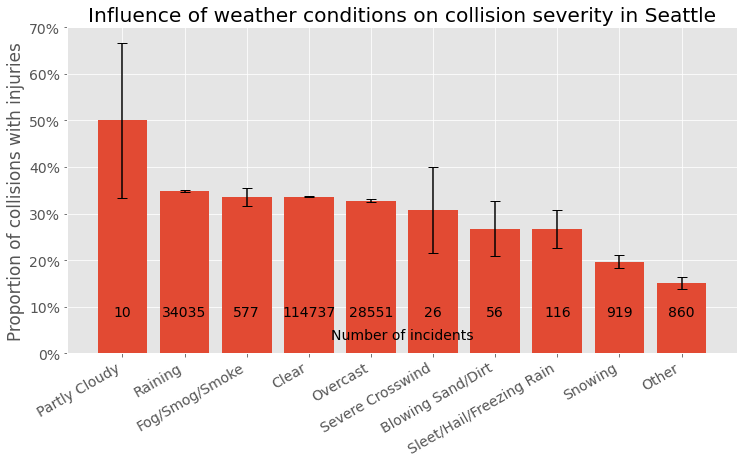

In [115]:
# create visualization of the influence of weather conditions on collision severity

fig = plt.figure(figsize = (12,6))

ax = fig.add_subplot(111)
plt.bar(list(df_weather.index), df_weather['mean'] * 100, yerr=df_weather['sem'] * 100, capsize=5)
plt.xticks(rotation=30, ha='right')

#plt.text(list(df_weather.index), 5, df_weather['count'])
for count in df_weather['count'].to_list():
    plt.text(df_weather['count'].to_list().index(count), 8, count, horizontalalignment='center')
    
plt.text(4.5, 3, 'Number of incidents', horizontalalignment='center')
    
plt.title('Influence of weather conditions on collision severity in Seattle')
plt.ylabel('Proportion of collisions with injuries')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig('weather.png')

The differences between the 'weather' classes are in general not very large. Only 'Snowing' and 'Other' display a substantially lower risk for collisions with injuries. It is likely that traffic is slower and people might be more attentative when it is snowing, which could explain the lower risk. One also needs to consider that the overwhelming majority of accidents occur when it is either 'clear', 'overcast' or 'raining'. Other weather conditions are very rarely reported.

Road conditions are subdivided into nine classes. One class is again 'Unknown' and will be removed. That reduces the data set by another 1,502 incidents.

In [116]:
# remove incidents with unknown road conditions

unknown = df[df['ROADCOND'] == 'Unknown'].shape[0]
print(unknown, 'incidents have been excluded because their values are unknown.')

df = df[df['ROADCOND'] != 'Unknown'].copy()

1502 incidents have been excluded because their values are unknown.


In [117]:
# get exploratory statistics about road conditions

df_road = df.groupby('ROADCOND')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])
df_road = df_road.sort_values('mean', ascending = False)
df_road

,count,mean,std,sem
ROADCOND,,,,
Oil,61,0.393443,0.492568,0.063067
Other,122,0.377049,0.486646,0.044059
Wet,48296,0.344728,0.475285,0.002163
Dry,127739,0.336553,0.472533,0.001322
Sand/Mud/Dirt,69,0.318841,0.469441,0.056514
Standing Water,112,0.294643,0.457931,0.043270
Ice,1158,0.250432,0.433449,0.012737
Snow/Slush,921,0.183496,0.387283,0.012761


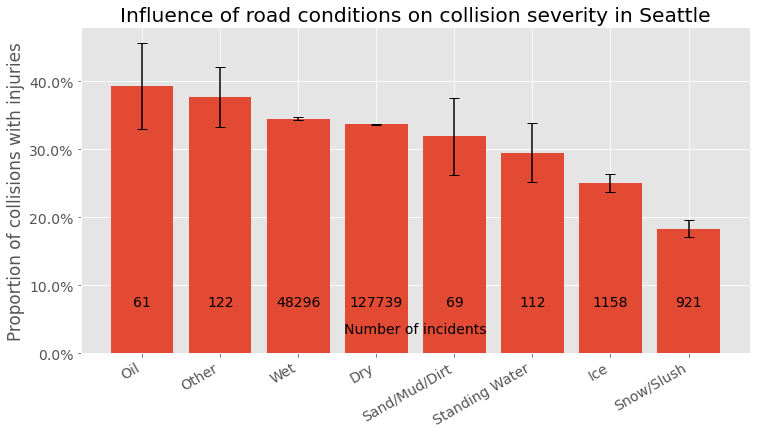

In [118]:
# create visualization of the influence of road conditions on collision severity

fig = plt.figure(figsize = (12,6))

ax = fig.add_subplot(111)
plt.bar(list(df_road.index), df_road['mean'] * 100, yerr=df_road['sem'] * 100, capsize=5)
plt.xticks(rotation=30, ha='right')

#plt.text(list(df_weather.index), 5, df_weather['count'])
for count in df_road['count'].to_list():
    plt.text(df_road['count'].to_list().index(count), 7, count, horizontalalignment='center')
    
plt.text(3.5, 3, 'Number of incidents', horizontalalignment='center')
    
plt.title('Influence of road conditions on collision severity in Seattle')
plt.ylabel('Proportion of collisions with injuries')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig('road.png')

Similarly to the weather conditions we can observe that most road conditions do not have a large influence on the probability of a severe collision. In accordance with the previous observation we can see that 'Ice' and 'Snow/Slush' are clearly displaying a lower risk for an accident with injury. However, we also need to note that most accidents are reported to have occurred while the road was either dry or wet.

The last environmental feature is the light condition. By removing the 'Unknown' class we lose another 2,374 incidents from our data set.

In [119]:
# remove incidents with unknown light conditions from the data set

unknown = df[df['LIGHTCOND'] == 'Unknown'].shape[0]
print(unknown, 'incidents have been excluded because their values are unknown.')

df = df[df['LIGHTCOND'] != 'Unknown'].copy()

2374 incidents have been excluded because their values are unknown.


In [120]:
# get exploratory statistics about light conditions

df_light = df.groupby('LIGHTCOND')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])
df_light = df_light.sort_values('mean', ascending = False)
df_light

,count,mean,std,sem
LIGHTCOND,,,,
Dark - Unknown Lighting,21,0.380952,0.497613,0.108588
Dawn,2530,0.351383,0.477497,0.009493
Dusk,5852,0.349966,0.477000,0.006235
Daylight,116216,0.349461,0.476802,0.001399
Dark - Street Lights On,48521,0.322005,0.467250,0.002121
Dark - Street Lights Off,1164,0.294674,0.456092,0.013368
Other,209,0.263158,0.441405,0.030533
Dark - No Street Lights,1458,0.243484,0.429332,0.011244


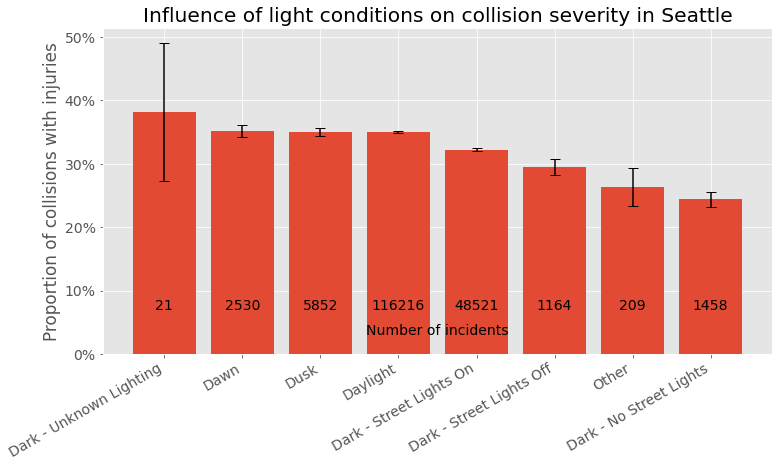

In [121]:
# create visualization of the influence of light conditions on collision severity

fig = plt.figure(figsize = (12,6))

ax = fig.add_subplot(111)
plt.bar(list(df_light.index), df_light['mean'] * 100, yerr=df_light['sem'] * 100, capsize=5)
plt.xticks(rotation=30, ha='right')

#plt.text(list(df_weather.index), 5, df_weather['count'])
for count in df_light['count'].to_list():
    plt.text(df_light['count'].to_list().index(count), 7, count, horizontalalignment='center')
    
plt.text(3.5, 3, 'Number of incidents', horizontalalignment='center')
    
plt.title('Influence of light conditions on collision severity in Seattle')
plt.ylabel('Proportion of collisions with injuries')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig('light.png')

Interestingly, adverse light conditions seem to negatively correlate with the severity of collision events. This further supports the hypothesis that difficult conditions increase the attention of drivers and promote more cautious driving. Similar to the other environmental features we need to keep in mind that the distribution of collision events is evenly distributed between classes at all. Almost all accidents are reported to occur at daylight or in the dark with the street lights on.

Even though we decided not to use the exact location of incidents due to the apparent lack of informative value there is some categorical information that we can use. One feature in the data set provides information about the junction type where the collision occurred. This could inform a driver and our classification algorithm about locations where the risk of a severe accident is higher or lower. We dismiss again the incidents that are labeled 'Unknown' which discards 8 rows.

In [122]:
# remove incidents with unknown junction type from the data set

unknown = df[df['JUNCTIONTYPE'] == 'Unknown'].shape[0]
print(unknown, 'incidents have been excluded because their values are unknown.')

df = df[df['JUNCTIONTYPE'] != 'Unknown'].copy()

8 incidents have been excluded because their values are unknown.


In [123]:
# get exploratory statistics about junction types

df_junction = df.groupby('JUNCTIONTYPE')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])
df_junction = df_junction.sort_values('mean', ascending = False)
df_junction

,count,mean,std,sem
JUNCTIONTYPE,,,,
At Intersection (intersection related),63399,0.451553,0.497651,0.001976
Ramp Junction,166,0.355422,0.480089,0.037262
At Intersection (but not related to intersection),1868,0.341006,0.474174,0.010971
Mid-Block (but intersection related),21931,0.334093,0.471683,0.003185
Driveway Junction,10303,0.322527,0.467466,0.004605
Mid-Block (not related to intersection),80502,0.256105,0.436483,0.001538


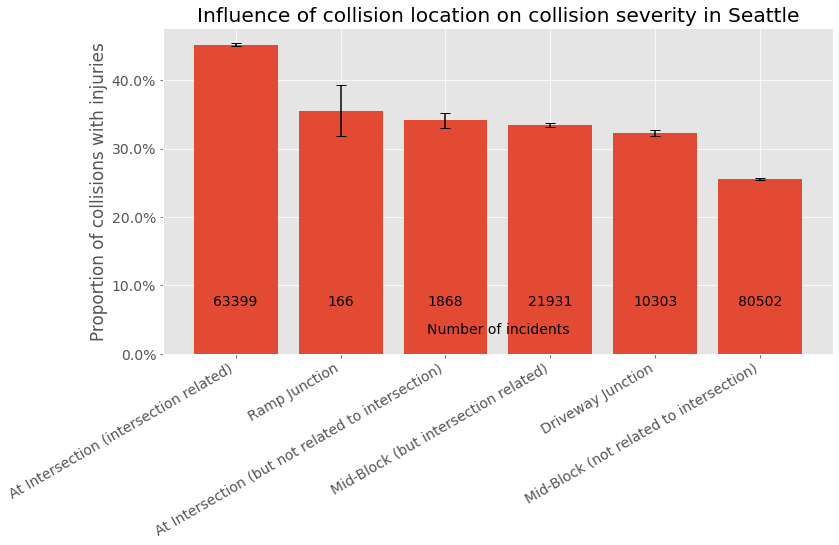

In [124]:
# create visualization of the influence of the junction type on collision severity

fig = plt.figure(figsize = (12,6))

ax = fig.add_subplot(111)
plt.bar(list(df_junction.index), df_junction['mean'] * 100, yerr=df_junction['sem'] * 100, capsize=5)
plt.xticks(rotation=30, ha='right')

for count in df_junction['count'].to_list():
    plt.text(df_junction['count'].to_list().index(count), 7, count, horizontalalignment='center')
    
plt.text(2.5, 3, 'Number of incidents', horizontalalignment='center')
    
plt.title('Influence of collision location on collision severity in Seattle')
plt.ylabel('Proportion of collisions with injuries')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig('junction.png')

This location feature might have a higher informative value than the previous environmental features. We can can clearly observe that collision that occur at intersections are substantially more severe than at any other location. Accidents that occur mid-block tend to be less severe than the rest. The other locations are somewhere in between and vary only mildly. A further contrast to the previous features is the more equal distribution of incidents between the classes. Most incidents are actually assigned to the two most extreme classes in terms of their influence on risk.

Besides environmental and location factors, we also have information about the time of collision events. From the timestamp of a reported incident we can extract categorical features that might improve the performance of our prediction algorithm. Unfortunately there are many incidents for which the exact time is not available. When we discard these incidents, we lose 27,923 rows. The first aspect we investigate is to what degree the hour of the day may influence the risk of a severe collision.

In [125]:
df.describe(include = 'all')

,SEVERITYCODE,INCDTTM,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,PEDES,CYCL,VEHIC
count,180893.000000,180893,178169,180893.000000,180893.000000,176020,176104,175965,180893.000000,180893.000000,180893.000000,180893.000000
unique,NaN,152416,6,NaN,NaN,10,8,8,NaN,NaN,NaN,NaN
top,NaN,11/2/2006,Mid-Block (not related to intersection),NaN,NaN,Clear,Dry,Daylight,NaN,NaN,NaN,NaN
freq,NaN,98,80502,NaN,NaN,112650,125997,116213,NaN,NaN,NaN,NaN
mean,0.337028,NaN,NaN,0.160642,0.052655,NaN,NaN,NaN,0.053883,0.043053,0.032174,0.972840
std,0.472696,NaN,NaN,0.367201,0.223345,NaN,NaN,NaN,0.225787,0.202977,0.176462,0.162549
min,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
25%,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000
50%,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000
75%,1.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000


In [126]:
# convert timestamp feature to coherent time date format
df['DATE_TIME'] = pd.to_datetime(df['INCDTTM'])

In [127]:
# remove incidents without time information

unknowns = df.loc[df['DATE_TIME'].dt.time == pd.to_datetime('00:00:00').time(),:].shape[0]
print(unknowns, 'incidents have been excluded due to the time of the accident being unknown.')

df = df.loc[df['DATE_TIME'].dt.time != pd.to_datetime('00:00:00').time(),:].copy()

27923 incidents have been excluded due to the time of the accident being unknown.


In [128]:
# extract YEAR, MONTH, HOUR, and DAYOFWEEK features from 'DATE_TIME' feature

df['YEAR'] = df['DATE_TIME'].dt.year
df['MONTH'] = df['DATE_TIME'].dt.month_name()
df['HOUR'] = df['DATE_TIME'].dt.hour
df['DAYOFWEEK'] = df['DATE_TIME'].dt.day_name()

In [129]:
# count the number of incidents and calculate the mean, standard deviation, and standard error of the proportion of collisions
# with injury per hour of the day
df_hour = df.groupby('HOUR')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])
df_hour

,count,mean,std,sem
HOUR,,,,
0,3403,0.280929,0.449519,0.007706
1,3234,0.287260,0.452554,0.007958
2,3367,0.283041,0.450543,0.007765
3,1539,0.250162,0.433247,0.011044
4,1147,0.266783,0.442471,0.013065
5,1587,0.330183,0.470427,0.011809
6,3003,0.363969,0.481220,0.008781
7,6148,0.368250,0.482369,0.006152
8,7875,0.352889,0.477899,0.005385


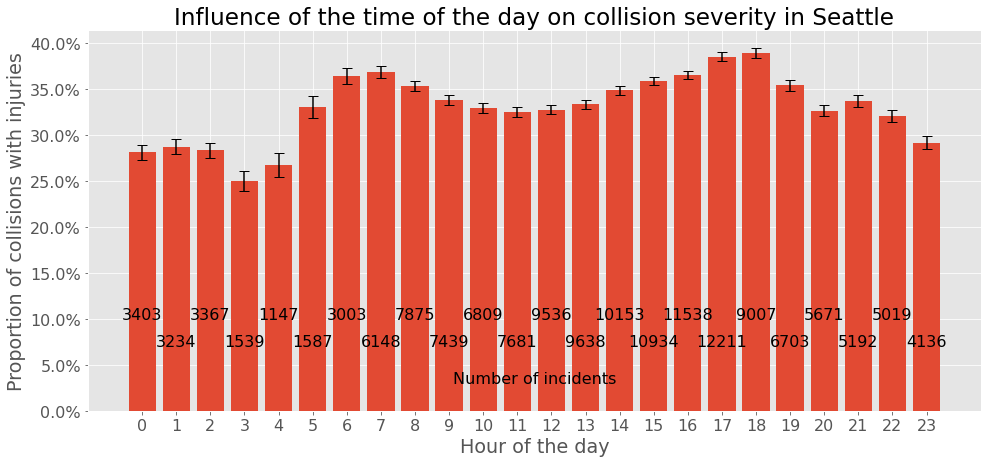

In [130]:
# create visualization of the influence of the hour of the day on collision severity

fig = plt.figure(figsize = (16,7))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
plt.bar(list(df_hour.index), df_hour['mean'] * 100, yerr=df_hour['sem'] * 100, capsize=5)
plt.xlabel('Hour of the day')
plt.title('Influence of the time of the day on collision severity in Seattle')
plt.ylabel('Proportion of collisions with injuries')

for count in df_hour['count'].to_list():
    if (df_hour['count'].to_list().index(count) % 2) == 0:
        text_ypos = 10
    else:
        text_ypos = 7
    
    plt.text(df_hour['count'].to_list().index(count), text_ypos, count, horizontalalignment='center')
    
plt.text(11.5, 3, 'Number of incidents', horizontalalignment='center')

plt.xticks(range(0, 24))

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig('hour.png')

We can recognize a pattern throughout a day. Typically the severity of accidents is the lowest during the night, which is in agreement with previous observations regarding the light conditions. Interestingly, the risk for a severe collision event seems to be the highest during the rush hours in the morning and in the evening with a trough in between.

Besides the time of the day, it could be beneficial to check whether the day of the week has an influence on the severity of accidents.

In [131]:
# declare the correct order of the days of the week
df['DAYOFWEEK'] = pd.Categorical(df['DAYOFWEEK'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)

# count the number of incidents and calculate the mean, standard deviation, and standard error of the proportion of collisions
# with injury per day of the week
df_day_of_week = df.groupby('DAYOFWEEK')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])

df_day_of_week

,count,mean,std,sem
DAYOFWEEK,,,,
Monday,20647,0.349833,0.476929,0.003319
Tuesday,22447,0.347574,0.476211,0.003178
Wednesday,22730,0.347558,0.476205,0.003159
Thursday,23074,0.353645,0.478111,0.003148
Friday,25362,0.339405,0.473517,0.002973
Saturday,21490,0.335179,0.472064,0.003220
Sunday,17220,0.321487,0.467061,0.003559


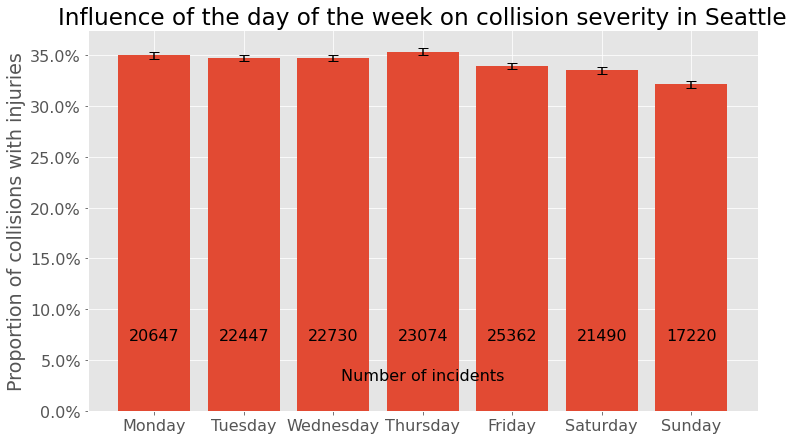

In [132]:
# create visualization of the influence of the day of the week on collision severity

fig = plt.figure(figsize = (12,7))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
plt.bar(list(df_day_of_week.index), df_day_of_week['mean'] * 100, yerr=df_day_of_week['sem'] * 100, capsize=5)

plt.title('Influence of the day of the week on collision severity in Seattle')
plt.ylabel('Proportion of collisions with injuries')

for count in df_day_of_week['count'].to_list():
    plt.text(df_day_of_week['count'].to_list().index(count), 7, count, horizontalalignment='center')
    
plt.text(3, 3, 'Number of incidents', horizontalalignment='center')


ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig('week.png')

The day of the week shows less distinct differences. Only Friday, Saturday and Sunday display a somewhat reduced risk for the severity of accidents.

After the time of the day and the day of the week, it is consistent to further consider the potential influence of a month.

In [133]:
# declare the correct order of months
df['MONTH'] = pd.Categorical(df['MONTH'], categories=
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
    ordered=True)

# count the number of incidents and calculate the mean, standard deviation, and standard error of the proportion of collisions
# with injury per month
df_month = df.groupby('MONTH')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])

df_month

,count,mean,std,sem
MONTH,,,,
January,12829,0.329020,0.469876,0.004148
February,11114,0.322476,0.467445,0.004434
March,12804,0.335130,0.472054,0.004172
April,12452,0.342515,0.474570,0.004253
May,13369,0.353878,0.478190,0.004136
June,13406,0.338654,0.473270,0.004088
July,13463,0.361212,0.480370,0.004140
August,12938,0.360488,0.480161,0.004221
September,12462,0.345530,0.475560,0.004260


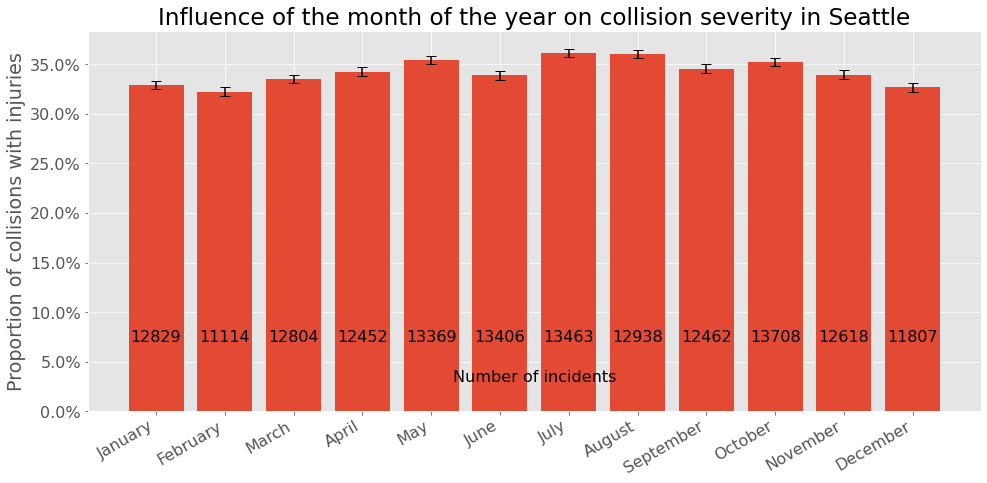

In [134]:
# create visualization of the influence of the month on collision severity

fig = plt.figure(figsize = (16,7))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
plt.bar(list(df_month.index), df_month['mean'] * 100, yerr=df_month['sem'] * 100, capsize=5)

plt.xticks(rotation=30, ha='right')

plt.title('Influence of the month of the year on collision severity in Seattle')
plt.ylabel('Proportion of collisions with injuries')

for count in df_month['count'].to_list():
    plt.text(df_month['count'].to_list().index(count), 7, count, horizontalalignment='center')
    
plt.text(5.5, 3, 'Number of incidents', horizontalalignment='center')

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig('month.png')

In general the months in the middle of the year, especially July and August, appear to be more risky. The winter months from December to February display a lower risk for accidents involving injuries. This is consistent with the previous observation that snowy weather is associated with a smaller proportion of severe collisions.

Last but not least, we will check whether there is a trend throughout the years from 2004 to 2020 in terms of road safety.

In [135]:
# count the number of incidents and calculate the mean, standard deviation, and standard error of the proportion of collisions
# with injury per year
df_year = df.groupby('YEAR')['SEVERITYCODE'].agg(['count', 'mean', 'std', 'sem'])
df_year

,count,mean,std,sem
YEAR,,,,
2004,7826,0.345771,0.475649,0.005377
2005,9906,0.329901,0.470201,0.004724
2006,9888,0.320692,0.466766,0.004694
2007,9360,0.307265,0.461385,0.004769
2008,8501,0.317727,0.465620,0.005050
2009,7220,0.349446,0.476828,0.005612
2010,9516,0.349517,0.476842,0.004888
2011,8894,0.333821,0.471603,0.005001
2012,9634,0.355823,0.478787,0.004878


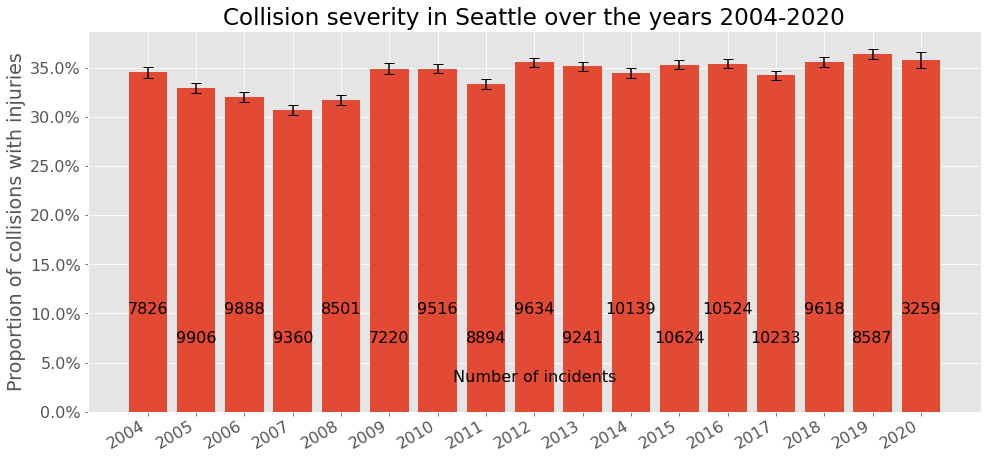

In [136]:
# create visualization of the influence of the year on collision severity

fig = plt.figure(figsize = (16,7))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
plt.bar(list(df_year.index), df_year['mean'] * 100, yerr=df_year['sem'] * 100, capsize=5)

plt.xticks(rotation=30, ha='right')

plt.title('Collision severity in Seattle over the years 2004-2020')
plt.ylabel('Proportion of collisions with injuries')

for count in df_year['count'].to_list():
    if (df_year['count'].to_list().index(count) % 2) == 0:
        text_ypos = 10
    else:
        text_ypos = 7

    plt.text(range(2004,2021)[df_year['count'].to_list().index(count)], text_ypos, count, horizontalalignment='center')
   
plt.text(2012, 3, 'Number of incidents', horizontalalignment='center')

plt.xticks(range(2004, 2021))

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig('year.png')

There is not much difference between years in regard to the severity of collisions. The years 2005 to 2008 display a significantly lower risk for collisions resulting in injuries. Overall one could maybe recognize a very light trend towards a higher proportion of collisions with injuries. Noteworthy is also the very low number of traffic accidents in 2020. The data set only contains events up to October 9 of 2020 but it is already clear that 2020 will have only about half the number of accidents of a typical year. This is most probably due to the ongoing COVID-19 pandemic and the resulting economic recession and reduced individual mobility. It is at least one positive aspect of an otherwise dire situation.

### Data description

After removing all incidents without a complete set of information, our data set was reduced from originally 221,525 to 152,970 entries. This number should still be sufficiently large to provide an adequate training for our classification algorithms. When we remove all columns that does not contain information that is useful or that only retrospectively describes collision events, we end up with a data set that has 12 columns - one target feature and 11 explanatory features. The eleven features that should predict the severity of a collision event are: the junction type, the weather, the road conditions, the light conditions, the involvement of at least one pedestrian, the involvement of at least one cyclist, the involvement of at least one vehicle, the year of the accident, the month, the day of the week, and the hour of the day. For comparison reasons we will also keep a data set that does not contain any of the additional features that we extracted. That means that the only explanatory features are the junction type, the weather, the road conditions, and the light conditions. This should allow us to estimate how much the additional features improved that performance of the classification algorithms.

In [137]:
# remove all columns that contain information with information that is not suitable to the goal of the project

df = df.drop(['INCDTTM',
              'INATTENTIONIND',
              'UNDERINFL',
              'SPEEDING',
              'DATE_TIME'
             ], axis = 1).copy()

In [138]:
# create a second data frame for comparison purposes that only contains predictive features that were already present in the
# original data set

df_orig = df.drop(['PEDES',
                   'CYCL',
                   'VEHIC',
                   'YEAR',
                   'MONTH',
                   'HOUR',
                   'DAYOFWEEK'
                ], axis = 1).copy()

### Data preparation

Before we can apply the classification algorithms, we need to prepare the data set accordingly. We will assume that all explanatory features, also the one relating to time, are categorical features. That means that we will need to perform a one-hot encoding on all of them. One-hot enconding means that we transform a single feature with multiple classes into many features that are only binary. This means that our data set subsequently contains 95 explanatory features instead of the former eleven. The data set without extracted features that we kept for comparison reasons contains 33 features after the one-hot encoding.

Before we apply the classification algorithms we need to address the imbalance in our data set. The data set contains 100,538 incidents with only property damage and 52,432 incidents that resulted in injury. A naive algorithm could always predict a collision without injury and would achieve about a 66% accuracy. Of course such a naive algorithm is not very useful. In order not to give a naive approach an unfair advantage we need to balance the data set. There are a couple of common methods available to balance an imbalanced data set. We will at this point not discuss all possible options. In this case we decided to apply over-sampling to our data set. This means that we randomly draw from samples from the minority class (collisions with injury) and add them to the data set until the the two classes are equally represented in the data set. After the over-sampling procedure our data set contains 201,076 incidents. The same procedure will also be performed on the comparison data set.

There are several well established classification algorithms. Because all our features are binary, we chose to train a support-vector machine, a decision tree, and a logistic regression algorithm. Unfortunately, it is not the scope of this case study to discuss the inner workings, and advantages and disadvantages of these algorithms. All three algorithms are supervised machine learning algorithms and require us to provide them with a training set and subsequently test their performance on a test set. For this reason we will randomly split the data set at a 7:3 ratio. This means the training set contains 70% and the test set 30% of all incidents. All algorithms will receive the same training set and will be evaluated on the same test set. To test and compare the performance of the algorithms we will assess them by calculating their accuracy and their F1 score.

In [139]:
# count number of incidents in each severity class
df.groupby('SEVERITYCODE')['SEVERITYCODE'].agg('count')

SEVERITYCODE
0    100538
1     52432
Name: SEVERITYCODE, dtype: int64

In [140]:
# convert the 'YEAR' and 'HOUR' features to strings in order to facilitate the one-hot encoding
df['YEAR'] = df['YEAR'].apply(str)
df['HOUR'] = df['HOUR'].apply(str)

In [141]:
# one-hot encoding of the engineered data set and the original data set
df_oh = pd.get_dummies(df)
df_orig_oh = pd.get_dummies(df_orig)

In [142]:
# uncomment to install 'imbalanced-learn' package
#!conda install -c conda-forge imbalanced-learn

^C


In [143]:
# uncomment to install 'scikit-learn' package
#!conda install -c conda-forge scikit-learn

^C


In [144]:
# separate the the target feature and the predictive features and store them in different data frames
y = df_oh['SEVERITYCODE']
X = df_oh.drop(['SEVERITYCODE'], axis = 1).copy()

In [145]:
# over-sample data set to correct for imbalance in the counts of incidents in each severity class
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample.fit_resample(X, y)

In [146]:
# split data set in training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X_over, y_over, test_size=0.3, random_state=4)

## Results

All three classification algorithma achieve an accuracy of over 62% and an F1 score of more than 0.62. The decision tree model achieves the best performance with an accuracy of 70% and an F1 score of 0.70. Looking at the confusion matrix of the output of the decision tree model we recognize that it is fairly balanced with a slight tendency of predicting more often 'injury' when it is actually 'property damage' than the other wrong assignment. Correspondigly the model is better at correctly identifying incidents that involved injury than those that involved only property damage.

The performance metrics of the classification algorithms in the data set that did not contain the extracted features were substantially worse. However, all algorithms performed almost equally well. All achieved an accuracy of 59% and an F1 score of 0.59. The confusion matrix is very balanced and shows approximately the same proportion of false positives and false negatives.

In [150]:
# train support-vector machine model
from sklearn import svm
suvema = svm.SVC(kernel='rbf')
suvema.fit(X_train, y_train)

SVC()

In [201]:
# use trained support-vector machine model to predict unlabeled incidents and calculate accuracy and F1 score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

yhat_SVM = suvema.predict(X_test)
print("SVM Accuracy:", format(accuracy_score(y_test, yhat_SVM), '.4f'))
print("SVM F1-score:", format(f1_score(y_test, yhat_SVM, average='weighted'), '.4f'))

SVM Accuracy: 0.6378
SVM F1-score: 0.6359


In [272]:
# define a function to plot a confusion matrix

from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [260]:
# change matplotlib plotting style for confusion matrices
mpl.style.use('default')

Confusion matrix, without normalization
[[17102 13088]
 [ 8764 21369]]


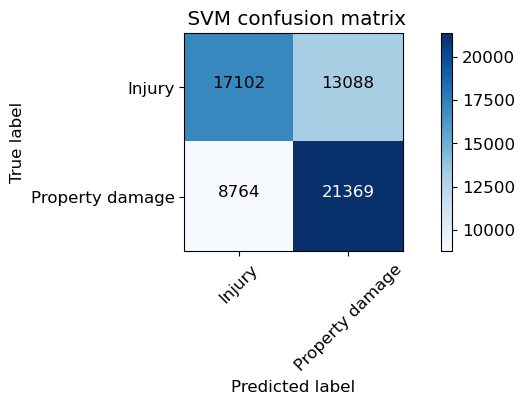

In [273]:
# get confusion matrix numbers
svm_matrix = confusion_matrix(y_test, yhat_SVM, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (8,4))
plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(svm_matrix, classes=['Injury','Property damage'],normalize= False,  title=' SVM confusion matrix')

In [153]:
# train decision tree model
from sklearn.tree import DecisionTreeClassifier
deciTree = DecisionTreeClassifier(criterion="entropy")
deciTree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [202]:
# use trained decision tree model to predict unlabeled incidents and calculate accuracy and F1 score
yhat_deciTree = deciTree.predict(X_test)
print("DT Accuracy:", format(accuracy_score(y_test, yhat_deciTree), '.4f'))
print("DT F1-score:", format(f1_score(y_test, yhat_deciTree, average='weighted'), '.4f'))

DT Accuracy: 0.6981
DT F1-score: 0.6979


Confusion matrix, without normalization
[[21899  8291]
 [ 9920 20213]]


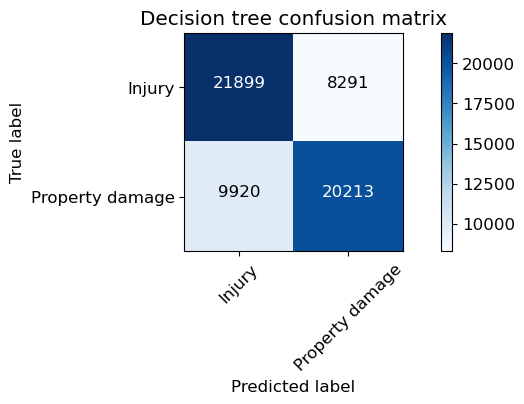

In [187]:
# get confusion matrix numbers
deciTree_matrix = confusion_matrix(y_test, yhat_deciTree, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (8,4))
plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(deciTree_matrix, classes=['Injury','Property damage'],normalize= False,
                      title='Decision tree confusion matrix')

In [278]:
# train logistic regression model
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

In [203]:
# use trained logistic regression model to predict unlabeled incidents and calculate accuracy and F1 score
yhat_LR = LR.predict(X_test)
print("LR Accuracy:", format(accuracy_score(y_test, yhat_LR), '.4f'))
print("LR F1-score:", format(f1_score(y_test, yhat_LR, average='weighted'), '.4f'))

LR Accuracy: 0.6297
LR F1-score: 0.6274
LR Log loss: 0.6199


Confusion matrix, without normalization
[[16680 13510]
 [ 8830 21303]]


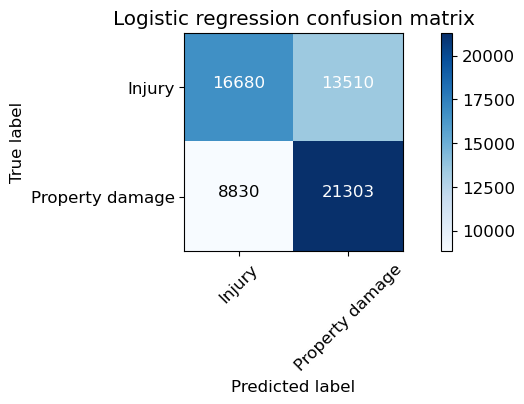

In [188]:
# get confusion matrix numbers
LR_matrix = confusion_matrix(y_test, yhat_LR, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (8,4))
plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(LR_matrix, classes=['Injury','Property damage'],normalize= False,
                      title='Logistic regression confusion matrix')

In [189]:
# separate the the target feature and the predictive features of the data set that does not contain the extracted features
y_orig = df_orig_oh['SEVERITYCODE']
X_orig = df_orig_oh.drop(['SEVERITYCODE'], axis = 1).copy()

In [190]:
# over-sample data set to correct for imbalance in the counts of incidents in each severity class
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')

X_orig_over, y_orig_over = oversample.fit_resample(X_orig, y_orig)

In [191]:
# split data set in training and test set
X_Otrain, X_Otest, y_Otrain, y_Otest = train_test_split( X_orig_over, y_orig_over, test_size=0.3, random_state=4)

In [248]:
# train support-vector machine model
suvemaO = svm.SVC(kernel='rbf')
suvemaO.fit(X_Otrain, y_Otrain)

SVC()

In [250]:
# use trained support-vector machine model to predict unlabeled incidents and calculate accuracy and F1 score
yhat_SVMO = suvemaO.predict(X_Otest)
print("SVM Accuracy:", format(accuracy_score(y_Otest, yhat_SVMO), '.4f'))
print("SVM F1-score:", format(f1_score(y_Otest, yhat_SVMO, average='weighted'), '.4f'))

SVM Accuracy: 0.5928
SVM F1-score: 0.5928


In [192]:
# train decision tree model
deciTreeO = DecisionTreeClassifier(criterion="entropy")
deciTreeO.fit(X_Otrain, y_Otrain)

DecisionTreeClassifier(criterion='entropy')

In [205]:
# use trained decision tree model to predict unlabeled incidents and calculate accuracy and F1 score
yhat_deciTreeO = deciTreeO.predict(X_Otest)
print("DT Accuracy:", format(accuracy_score(y_test, yhat_deciTreeO), '.4f'))
print("DT F1-score:", format(f1_score(y_Otest, yhat_deciTreeO, average='weighted'), '.4f'))

DT Accuracy: 0.5929
DT F1-score: 0.5929


Confusion matrix, without normalization
[[17929 12261]
 [12297 17836]]


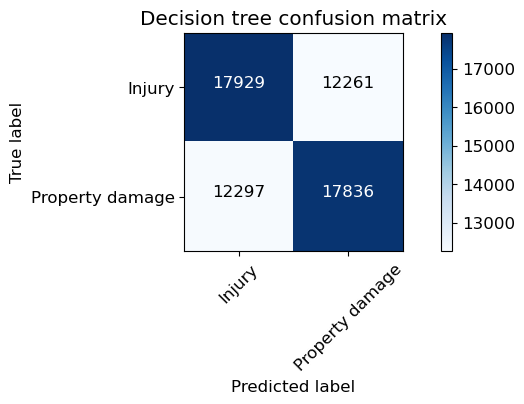

In [274]:
# get confusion matrix numbers
deciTreeO_matrix = confusion_matrix(y_Otest, yhat_deciTreeO, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (8,4))
plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(deciTreeO_matrix, classes=['Injury','Property damage'],normalize= False,
                      title='Decision tree confusion matrix')

In [254]:
# train logistic regression model
LRO = LogisticRegression(C=0.01, solver='liblinear').fit(X_Otrain,y_Otrain)

In [256]:
# use trained logistic regression model to predict unlabeled incidents and calculate accuracy and F1 score
yhat_LRO = LRO.predict(X_Otest)
print("LR Accuracy:", format(accuracy_score(y_Otest, yhat_LRO), '.4f'))
print("LR F1-score:", format(f1_score(y_Otest, yhat_LRO, average='weighted'), '.4f'))
#yhat_LROprob = LRO.predict_proba(X_Otest)
#print("LR Log loss:", format(log_loss(y_Otest, yhat_LROprob), '.4f'))

LR Accuracy: 0.5928
LR F1-score: 0.5919
LR Log loss: 0.6722


In [209]:
# aggregate different performance scores that were derived from the main data set

scores = pd.DataFrame({'Algorithm': ['Support-vector machine', 'Decision tree', 'Logistic regression'],
                       'F1': [f1_score(y_test, yhat_SVM, average='weighted'),
                             f1_score(y_test, yhat_deciTree, average='weighted'),
                             f1_score(y_test, yhat_LR, average='weighted')],
                       'Accuracy': [accuracy_score(y_test, yhat_SVM),
                             accuracy_score(y_test, yhat_deciTree),
                             accuracy_score(y_test, yhat_LR)]})

scores = scores.set_index('Algorithm')
scores

,F1,Accuracy
Algorithm,,
Support-vector machine,0.635904,0.637750
Decision tree,0.697880,0.698109
Logistic regression,0.627445,0.629660


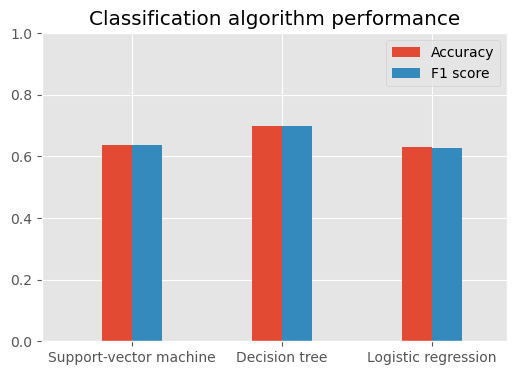

In [247]:
# visualize the performance scores that were derived from the main data set

mpl.style.use('ggplot')

fig = plt.figure(figsize = (6,4))
plt.rcParams.update({'font.size': 10})

bar_width = 0.2

x = np.arange(3)

ax = fig.add_subplot(111)
plt.bar(x,scores['Accuracy'], width = bar_width)
plt.bar(x + bar_width,scores['F1'], width = bar_width)

plt.title('Classification algorithm performance')

ax.set_ylim([0,1])
ax.set_xlim([-0.5,2.6])

ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(list(scores.index))

plt.legend(('Accuracy', 'F1 score'))

plt.savefig('performance.png')

In [257]:
# aggregate different performance scores that were derived from the data set that does not contain extracted features

scores_orig = pd.DataFrame({'Algorithm': ['Support-vector machine', 'Decision tree', 'Logistic regression'],
                       'F1': [f1_score(y_Otest, yhat_SVMO, average='weighted'),
                             f1_score(y_Otest, yhat_deciTreeO, average='weighted'),
                             f1_score(y_Otest, yhat_LRO, average='weighted')],
                       'Accuracy': [accuracy_score(y_Otest, yhat_SVMO),
                             accuracy_score(y_Otest, yhat_deciTreeO),
                             accuracy_score(y_Otest, yhat_LRO)]})

scores_orig = scores_orig.set_index('Algorithm')
scores_orig

,F1,Accuracy
Algorithm,,
Support-vector machine,0.592791,0.592792
Decision tree,0.592891,0.592892
Logistic regression,0.591874,0.592809


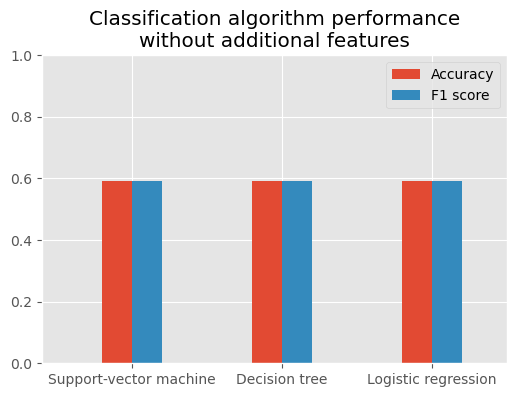

In [258]:
# visualize performance of algorithms were applied to the data set that did not contain the extracted features

mpl.style.use('ggplot')

fig = plt.figure(figsize = (6,4))
plt.rcParams.update({'font.size': 10})

bar_width = 0.2

x = np.arange(3)

ax = fig.add_subplot(111)
plt.bar(x,scores_orig['Accuracy'], width = bar_width)
plt.bar(x + bar_width,scores_orig['F1'], width = bar_width)

plt.title('Classification algorithm performance\nwithout additional features')

ax.set_ylim([0,1])
ax.set_xlim([-0.5,2.6])

ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(list(scores.index))

plt.legend(('Accuracy', 'F1 score'))

plt.savefig('performance_orig.png')

## Discussion

When we assess the performance scores of the models it is important to consider the worst possible scores as the baseline. In a perfectly balanced data set we could employ a naive algorithm that only prodicts collisions with injuries or without. Such an algorithm would be correct in 50% of all cases. That means that such an algorithm would also have a 50% accuracy. Hence, 50% accuracy should be regarded as our baseline. The best performing algorithm was the decision tree model that achieved 70% accuracy and an F1 score of 0.70. This is substantially better than the hypothetical naive algorithm that we proposed before. One might be thinking that such an accuracy is still not particularly good. However, we also need to consider that the information at our disposal to make these predictions is rather crude and is based on only comparably few features. With this consideration in mind it is actually quite remarkable that our model is able to predict situations reasonably accurately in which the outcome of a collision event is more severe.

The performance of the model could be improved if more information about the collision events would be available. At the moment, the model has to treat every incident equally even though in some incidents more than one person might have been injured. Such collision events should correspondingly receive a higher weight when the model is trained. Furthermore, the quality of the available data was not without doubt. Occasionally there were incidents that had a combination of information that seemed contradictory. A better understanding of the data and maybe also a check for consistency might improve the data quality and thus the model performance.

## Conclusion

The goal of this case study was to investigate whether we can use information about environmental factors to predict the severity of traffic collision events. We wanted to train a model with publicly available data from the City of Seattle to inform drivers and other traffic participants about conditions that favor a more or less severe outcome of a potential collision event.

We showed that by analyzing the data set and extracting further information we can train a machine learning model that has a substantially higher performance and accuracy than an approach that would be based purely on guessing based on the proportion of more severe accidents. Such a model could hypothetically be used to warn drivers about dangerous conditions and situations. If used on a wide scale, it could potentially reduce the number of severe collision events and protect the health and lives of a large number of people.